# Model comparison: Logistic Regression vs Random Forest

In [34]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_curve, auc, precision_recall_curve, average_precision_score,
                             accuracy_score, precision_score, recall_score, f1_score)
from sklearn.preprocessing import StandardScaler

sns.set(style="whitegrid")
ARTIFACTS = os.path.join('artifacts')
os.makedirs(ARTIFACTS, exist_ok=True)
print('Artifacts directory:', ARTIFACTS)

Artifacts directory: artifacts


In [35]:
df = pd.read_csv('data/telco_raw.csv')
print('Loaded', df.shape)
df.head(2)

Loaded (7043, 50)


,Customer ID,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Country,State,...,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Satisfaction Score,Customer Status,Churn Label,Churn Score,CLTV,Churn Category,Churn Reason
0,8779-QRDMV,Male,78,No,Yes,No,No,0,United States,California,...,20,0.0,59.65,3,Churned,Yes,91,5433,Competitor,Competitor offered more data
1,7495-OOKFY,Female,74,No,Yes,Yes,Yes,1,United States,California,...,0,390.8,1024.10,3,Churned,Yes,69,5302,Competitor,Competitor made better offer


In [36]:
target = 'Churn Label' if 'Churn Label' in df.columns else ('Churn' if 'Churn' in df.columns else None)
assert target is not None, 'Target column not found'

drop_cols = [c for c in df.columns if c.lower().strip() in ('customer id','customerid','customer')]
leak_cols = [c for c in df.columns if ('churn' in c.lower() and c != target) or c.lower().strip()=='customer status']
drop_list = [c for c in ([target] + drop_cols + leak_cols) if c in df.columns]
print('Dropping', drop_list)
X = df.drop(columns=drop_list)
y = df[target].map({'Yes':1,'No':0,'yes':1,'no':0}).fillna(0).astype(int)

for col in ['TotalCharges','Total Charges','Total_Charges','Monthly Charge','MonthlyCharge','Monthly Charges']:
    if col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce')

if 'tenure' in X.columns:
    X['tenure_months'] = pd.to_numeric(X['tenure'], errors='coerce')
elif 'Tenure in Months' in X.columns:
    X['tenure_months'] = pd.to_numeric(X['Tenure in Months'], errors='coerce')
if 'tenure_months' in X.columns:
    X['tenure_bucket'] = pd.cut(X['tenure_months'], bins=[-1,1,12,24,48,1000], labels=['0-1','1-12','12-24','24-48','48+'])

if 'Internet Service' in X.columns:
    X['has_internet'] = (~X['Internet Service'].isin(['No','None',None])).astype(int)

binary_map = {'Yes':1,'No':0,'yes':1,'no':0,'No internet service':0,'No phone service':0}
binary_cols = ['Online Security','Online Backup','Device Protection Plan','Premium Tech Support',
               'Streaming TV','Streaming Movies','Streaming Music','Unlimited Data','Phone Service','Multiple Lines']
for col in binary_cols:
    if col in X.columns:
        X[col + '_bin'] = X[col].map(binary_map).fillna(0).astype(int)

cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
high_card = [c for c in cat_cols if X[c].nunique() > 40]
if high_card:
    print('Dropping high-cardinality cols:', high_card)
X_enc = X.drop(columns=high_card)
X_enc = pd.get_dummies(X_enc, drop_first=True)

num_cols = X_enc.select_dtypes(include=['number']).columns
for col in num_cols:
    if X_enc[col].isna().any():
        X_enc[col] = X_enc[col].fillna(X_enc[col].median())

print('Final feature matrix shape:', X_enc.shape)
X_enc.head(1)

Dropping ['Churn Label', 'Customer ID', 'Customer Status', 'Churn Score', 'Churn Category', 'Churn Reason']
Dropping high-cardinality cols: ['City']
Final feature matrix shape: (7043, 62)


,Age,Number of Dependents,Zip Code,Latitude,Longitude,Population,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,...,Unlimited Data_Yes,Contract_One Year,Contract_Two Year,Paperless Billing_Yes,Payment Method_Credit Card,Payment Method_Mailed Check,tenure_bucket_1-12,tenure_bucket_12-24,tenure_bucket_24-48,tenure_bucket_48+
0,78,0,90022,34.02381,-118.156582,68701,0,1,0.0,8,...,False,False,False,True,False,False,False,False,False,False


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.2, random_state=42, stratify=y)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

num_cols = X_train.select_dtypes(include=['number']).columns.tolist()
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='median')
imp.fit(X_train[num_cols])
X_train_imp = imp.transform(X_train[num_cols])
X_test_imp = imp.transform(X_test[num_cols])
scaler = StandardScaler()
scaler.fit(X_train_imp)
X_train_scaled = scaler.transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

X_train_scaled_df = X_train.copy()
X_test_scaled_df = X_test.copy()
X_train_scaled_df[num_cols] = X_train_scaled
X_test_scaled_df[num_cols] = X_test_scaled

clf_lr = LogisticRegression(max_iter=1000, random_state=42)
clf_rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
clf_lr.fit(X_train_scaled_df, y_train)
clf_rf.fit(X_train, y_train)
print('LR train score:', clf_lr.score(X_train_scaled_df, y_train), 'val score:', clf_lr.score(X_test_scaled_df, y_test))
print('RF train score:', clf_rf.score(X_train, y_train), 'val score:', clf_rf.score(X_test, y_test))

Train shape: (5634, 62) Test shape: (1409, 62)
LR train score: 0.9646787362442315 val score: 0.9630943931866572
RF train score: 1.0 val score: 0.9538679914833215


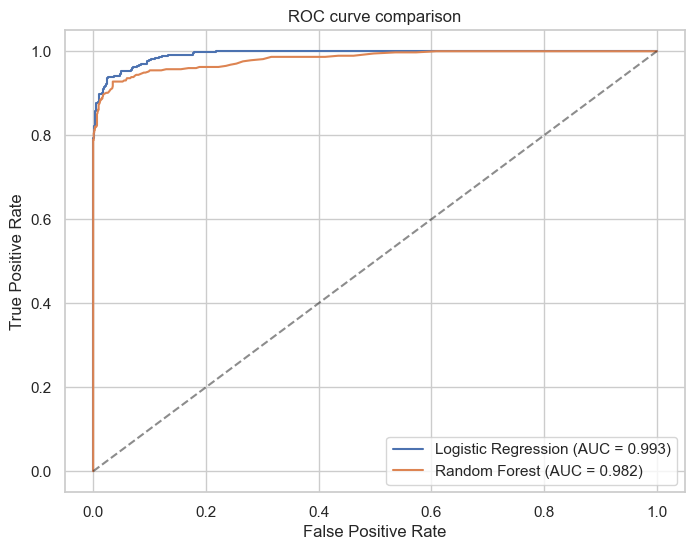

Saved ROC to artifacts\roc_comparison.png


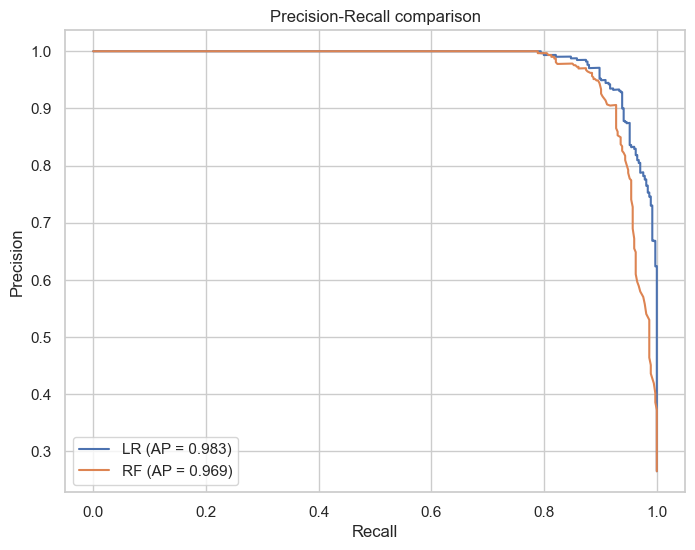

Saved PR to artifacts\pr_comparison.png


In [ ]:
y_prob_lr = clf_lr.predict_proba(X_test_scaled_df)[:,1]
y_prob_rf = clf_rf.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_lr = auc(fpr_lr, tpr_lr)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.3f})')
plt.plot([0,1],[0,1],'k--',alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve comparison')
plt.legend(loc='lower right')
roc_path = os.path.join(ARTIFACTS, 'roc_comparison.png')
plt.savefig(roc_path, bbox_inches='tight')
plt.show()
print('Saved ROC to', roc_path)

pr_lr_prec, pr_lr_rec, _ = precision_recall_curve(y_test, y_prob_lr)
pr_rf_prec, pr_rf_rec, _ = precision_recall_curve(y_test, y_prob_rf)
ap_lr = average_precision_score(y_test, y_prob_lr)
ap_rf = average_precision_score(y_test, y_prob_rf)
plt.figure(figsize=(8,6))
plt.plot(pr_lr_rec, pr_lr_prec, label=f'LR (AP = {ap_lr:.3f})')
plt.plot(pr_rf_rec, pr_rf_prec, label=f'RF (AP = {ap_rf:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall comparison')
plt.legend()
pr_path = os.path.join(ARTIFACTS, 'pr_comparison.png')
plt.savefig(pr_path, bbox_inches='tight')
plt.show()
print('Saved PR to', pr_path)

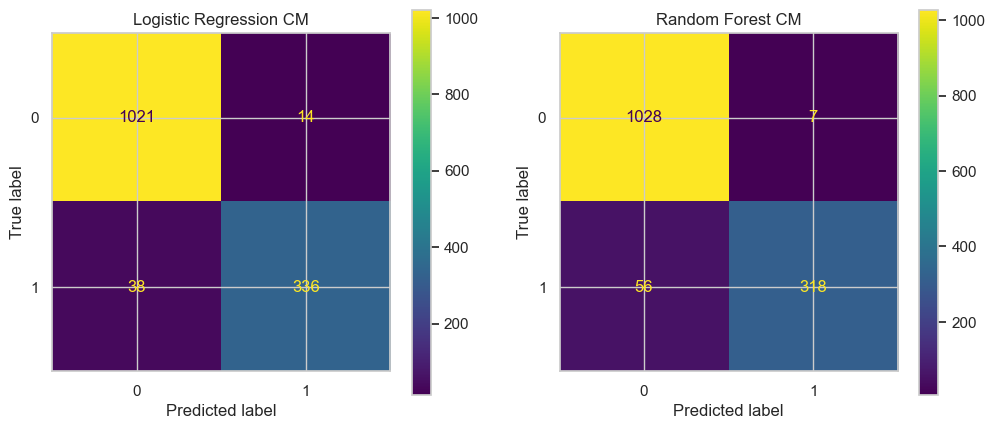

Saved confusion matrices to artifacts\confusion_matrices.png


In [ ]:
y_pred_lr = (y_prob_lr >= 0.5).astype(int)
y_pred_rf = (y_prob_rf >= 0.5).astype(int)

fig, ax = plt.subplots(1,2,figsize=(12,5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, ax=ax[0])
ax[0].set_title('Logistic Regression CM')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, ax=ax[1])
ax[1].set_title('Random Forest CM')
cm_path = os.path.join(ARTIFACTS, 'confusion_matrices.png')
plt.savefig(cm_path, bbox_inches='tight')
plt.show()
print('Saved confusion matrices to', cm_path)

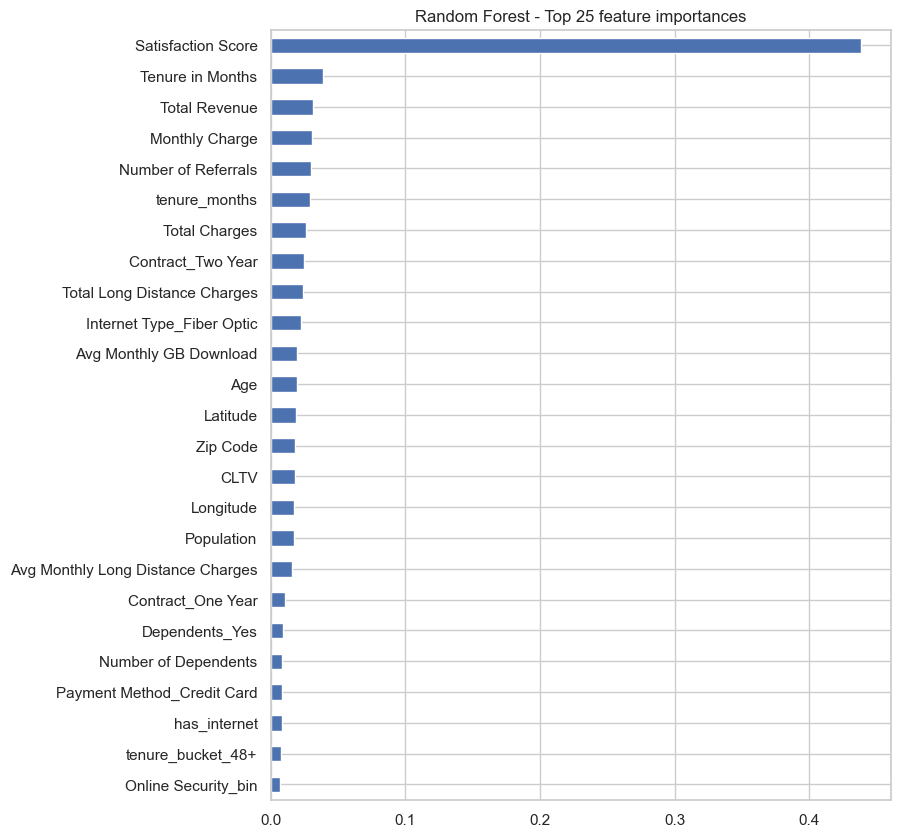

Saved RF feature importances to artifacts\rf_feature_importances.png


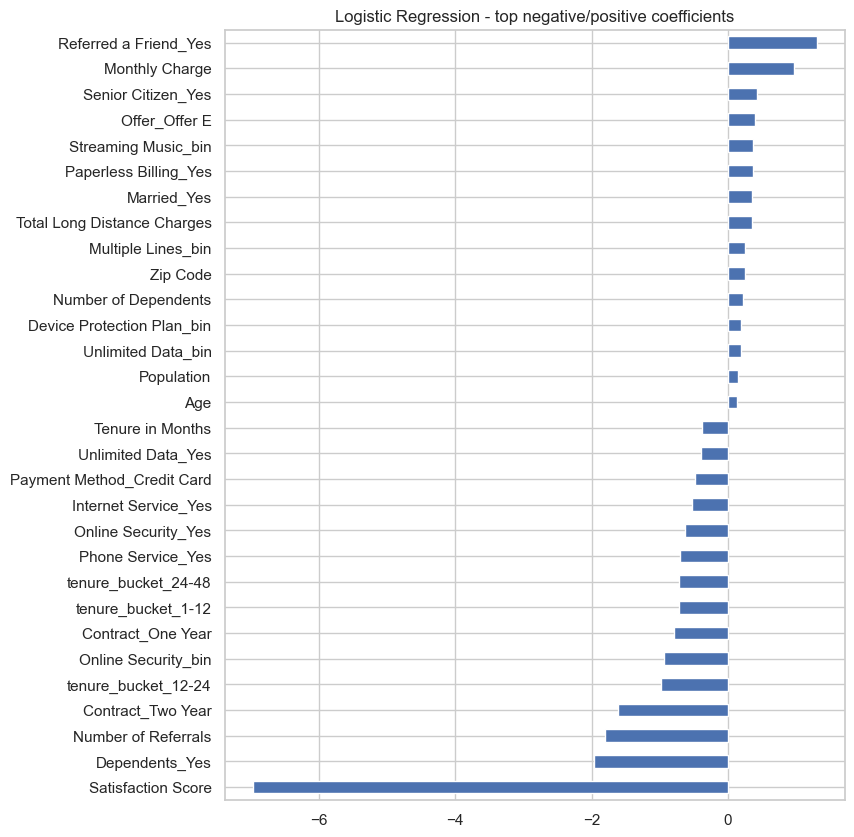

Saved LR coefficients to artifacts\lr_coefficients.png
--- Logistic Regression ---
Accuracy: 0.9630943931866572
Precision: 0.96
Recall: 0.8983957219251337
F1: 0.9281767955801105
ROC AUC: 0.99280012400217
--- Random Forest ---
Accuracy: 0.9552874378992193
Precision: 0.9784615384615385
Recall: 0.8502673796791443
F1: 0.9098712446351931
ROC AUC: 0.9818543491177762


In [ ]:
feat_names = X_train.columns.tolist()
if hasattr(clf_rf, 'feature_importances_'):
    fi = pd.Series(clf_rf.feature_importances_, index=feat_names).sort_values(ascending=False)
    plt.figure(figsize=(8,10))
    fi.head(25).sort_values().plot(kind='barh')
    fi_path = os.path.join(ARTIFACTS, 'rf_feature_importances.png')
    plt.savefig(fi_path, bbox_inches='tight')
    plt.show()
    print('Saved RF feature importances to', fi_path)

if hasattr(clf_lr, 'coef_'):
    coefs = pd.Series(clf_lr.coef_[0], index=feat_names).sort_values()
    plt.figure(figsize=(8,10))
    pd.concat([coefs.head(15), coefs.tail(15)]).plot(kind='barh')
    lr_coef_path = os.path.join(ARTIFACTS, 'lr_coefficients.png')
    plt.savefig(lr_coef_path, bbox_inches='tight')
    plt.show()
    print('Saved LR coefficients to', lr_coef_path)

def summarize(name, y_true, y_pred, y_prob):
    print(f'--- {name} ---')
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('Precision:', precision_score(y_true, y_pred))
    print('Recall:', recall_score(y_true, y_pred))
    print('F1:', f1_score(y_true, y_pred))
    print('ROC AUC:', auc(*roc_curve(y_true, y_prob)[:2]))

summarize('Logistic Regression', y_test, y_pred_lr, y_prob_lr)
summarize('Random Forest', y_test, y_pred_rf, y_prob_rf)